# Clustering Geolocation Data Intelligently in Python
We have taxi rank locations, and want to define key clusters of these taxis where we can build service stations for all taxis operating in that region.


## Project Outline

[**Task 1**](#task1): Exploratory Data Analysis

[**Task 2**](#task2): Visualizing Geographical Data

[**Task 3**](#task3): Clustering Strength / Performance Metric

[**Task 4**](#task4): K-Means Clustering

[**Task 5**](#task5): DBSCAN

In [3]:
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np

from tqdm import tqdm

from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict

#import hdbscan
import folium
import re


cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

<a id='task1'></a>
# Task 1: Exploratory Data Analysis

In [4]:
df = pd.read_csv('Data/taxi_data.csv')

In [5]:
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


In [6]:
df.duplicated(subset=['LON', 'LAT']).values.any()

True

In [7]:
df.isna().values.any()

True

In [8]:
print(f'Before dropping NaNs and dupes\t:\tdf.shape = {df.shape}')
df.dropna(inplace=True)
df.drop_duplicates(subset=['LON', 'LAT'], keep='first', inplace=True)
print(f'After dropping NaNs and dupes\t:\tdf.shape = {df.shape}')

Before dropping NaNs and dupes	:	df.shape = (838, 3)
After dropping NaNs and dupes	:	df.shape = (823, 3)


In [9]:
df.head()

,LON,LAT,NAME
0,28.17858,-25.73882,11th Street Taxi Rank
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank
2,27.83239,-26.53722,Adams Road Taxi Rank
3,28.12514,-26.26666,Alberton City Mall Taxi Rank
4,28.10144,-26.10567,Alexandra Main Taxi Rank


In [10]:
X = np.array(df[['LON', 'LAT']], dtype='float64')

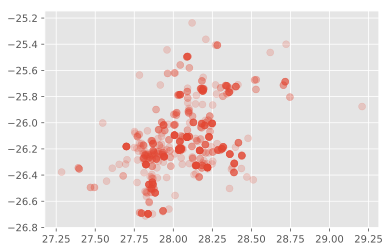

In [11]:
plt.scatter(X[:,0], X[:,1], alpha=0.2, s=50)

<a id='task2'></a>
# Task 2: Visualizing Geographical Data


In [12]:
m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, 
               tiles='Stamen Toner')

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row.LAT, row.LON],
        radius=5,
        popup=re.sub(r'[^a-zA-Z ]+', '', row.NAME),
        color='#1787FE',
        fill=True,
        fill_colour='#1787FE'
    ).add_to(m)

In [13]:
m

<a id='task3'></a>
# Task 3: Clustering Strength / Performance Metric

In [14]:
X_blobs, _ = make_blobs(n_samples=1000, centers=10, n_features=2, 
                        cluster_std=0.5, random_state=4)

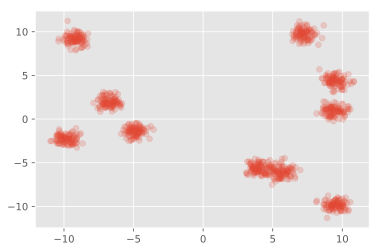

In [15]:
plt.scatter(X_blobs[:,0], X_blobs[:,1], alpha=0.2)

In [16]:
class_predictions = np.load('Data/sample_clusters.npy')

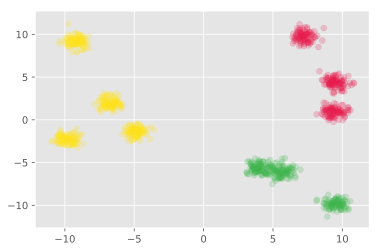

In [17]:
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [18]:
silhouette_score(X_blobs, class_predictions)

0.6657220862867241

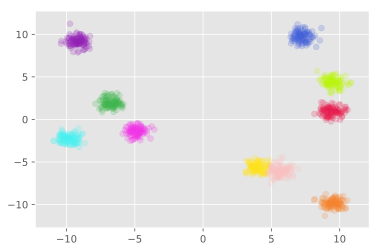

In [19]:
class_predictions = np.load('Data/sample_clusters_improved.npy')
unique_clusters = np.unique(class_predictions)
for unique_cluster in unique_clusters:
    X = X_blobs[class_predictions==unique_cluster]
    plt.scatter(X[:,0], X[:,1], alpha=0.2, c=cols[unique_cluster])

In [20]:
silhouette_score(X_blobs, class_predictions)

0.7473587799908298

<a id='task4'></a>
# Task 4: K-Means Clustering

In [21]:
X_blobs, _ = make_blobs(n_samples=1000, centers=50, 
                        n_features=2, cluster_std=1, random_state=4)

In [22]:
data = defaultdict(dict)
for x in range(1,21):
    model = KMeans(n_clusters=3, random_state=17, 
                   max_iter=x, n_init=1).fit(X_blobs)
    
    data[x]['class_predictions'] = model.predict(X_blobs)
    data[x]['centroids'] = model.cluster_centers_
    data[x]['unique_classes'] = np.unique(class_predictions)

In [23]:
def f(x):
    class_predictions = data[x]['class_predictions']
    centroids = data[x]['centroids']
    unique_classes = data[x]['unique_classes']

    for unique_class in unique_classes:
            plt.scatter(X_blobs[class_predictions==unique_class][:,0], 
                        X_blobs[class_predictions==unique_class][:,1], 
                        alpha=0.3, c=cols[unique_class])
    plt.scatter(centroids[:,0], centroids[:,1], s=200, c='#000000', marker='v')
    plt.ylim([-15,15]); plt.xlim([-15,15])
    plt.title('How K-Means Clusters')

interactive_plot = interactive(f, x=(1, 20))
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(IntSlider(value=10, description='x', max=20, min=1), Output(layout=Layout(height='350px'…

In [24]:
X = np.array(df[['LON', 'LAT']], dtype='float64')
k = 70
model = KMeans(n_clusters=k, random_state=17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

In [25]:
df.head()

,LON,LAT,NAME,CLUSTER_kmeans70
0,28.17858,-25.73882,11th Street Taxi Rank,1
1,28.17660,-25.73795,81 Bazaar Street Taxi Rank,1
2,27.83239,-26.53722,Adams Road Taxi Rank,9
3,28.12514,-26.26666,Alberton City Mall Taxi Rank,8
4,28.10144,-26.10567,Alexandra Main Taxi Rank,4


In [26]:
def create_map(df, cluster_column):
    m = folium.Map(location=[df.LAT.mean(), df.LON.mean()], zoom_start=9, tiles='Stamen Toner')

    for _, row in df.iterrows():

        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]

        folium.CircleMarker(
            location= [row['LAT'], row['LON']],
            radius=5,
            popup= row[cluster_column],
            color=cluster_colour,
            fill=True,
            fill_color=cluster_colour
        ).add_to(m)
        
    return m

m = create_map(df, 'CLUSTER_kmeans70')
print(f'K={k}')
print(f'Silhouette Score: {silhouette_score(X, class_predictions)}')

m.save('kmeans_70.html')

K=70
Silhouette Score: 0.6527069281188838


In [27]:
m

In [28]:
best_silhouette, best_k = -1, 0

for k in tqdm(range(2, 100)):
    model = KMeans(n_clusters=k, random_state=1).fit(X)
    class_predictions = model.predict(X)
    
    curr_silhouette = silhouette_score(X, class_predictions)
    if curr_silhouette > best_silhouette:
        best_k = k
        best_silhouette = curr_silhouette
        
print(f'K={best_k}')
print(f'Silhouette Score: {best_silhouette}') 

100%|██████████████████████████████████████████████████████████████████████████████████| 98/98 [00:24<00:00,  1.73it/s]


K=99
Silhouette Score: 0.7084996241477046


<a id='task5'></a>
# Task 5: DBSCAN 
Density-Based Spatial Clustering of Applications with Noise

In [29]:
# code for indexing out certain values
dummy = np.array([-1, -1, -1, 2, 3, 4, 5, -1])

new = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(dummy)])

In [30]:
model = DBSCAN(eps=0.01, min_samples=5).fit(X)
class_predictions = model.labels_

df['CLUSTERS_DBSCAN'] = class_predictions

In [31]:
m = create_map(df, 'CLUSTERS_DBSCAN')

    
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Number of outliers found: {len(class_predictions[class_predictions==-1])}')

print(f'Silhouette ignoring outliers: {silhouette_score(X[class_predictions!=-1], class_predictions[class_predictions!=-1])}')

no_outliers = 0
no_outliers = np.array([(counter+2)*x if x==-1 else x for counter, x in enumerate(class_predictions)])
print(f'Silhouette outliers as singletons: {silhouette_score(X, no_outliers)}')

Number of clusters found: 51
Number of outliers found: 289
Silhouette ignoring outliers: 0.9232138250288208
Silhouette outliers as singletons: 0.5667489350583482


In [32]:
m